### Extra four test sets

In [1]:
import os
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
from scipy import stats
# from deside.utility import cancer_types, check_dir, read_marker_gene, calculate_rmse, set_fig_style
from deside.decon_cf import DeSide
from deside.utility.read_file import read_gene_set
from deside.utility.compare import read_and_merge_result, cal_gene_signature_score
from deside.utility import (ExpObj, set_fig_style, sorted_cell_types, read_marker_gene,
                            get_corr, check_dir, cancer_types, get_ccc, 
                            read_cancer_purity, calculate_rmse, print_df)
# sns.set(font_scale=2)
# sns.set_style("white")
from sklearn.metrics import median_absolute_error
set_fig_style(font_family='Arial', font_size=8)

2024-06-21 18:58:58.467160: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
fig_dir = './fig4/'
dataset_dir = '../datasets/'
result_dir = '../results/whole_workflow_20231110_12ds_subtypes/DeSide_03_new_ds_subtypes_all_range/'

---

## 1. Dataset (GSE184398) - flow score (acquired from experiment)
- From Combes et al., 2022, Cell 185, 184–203
- The most common stromal cells include fibroblasts and pericytes. 

In [3]:
pred_cell_prop_dir = os.path.join(result_dir, 'Mixed_N100K_segment_filtered-Mixed_N100K_segment_without_filtering')
result_dir = os.path.join(pred_cell_prop_dir, 'ind_test_set')
ind_dataset_dir = os.path.join(dataset_dir, 'Independent_Test_Set')
check_dir(result_dir)

In [4]:
flow_score = pd.read_csv('../datasets/Independent_Test_Set/Combes et al., 2022, Cell/flow_score.csv', index_col=0)
print(flow_score.shape)
flow_score.head(2)

(224, 10)


,Tcells,Myeloid,Stroma,CD4,CD8,treg,Classical mono,Macro,cDC1,cDC2
IPICRC058.T1,NaN,NaN,NaN,NaN,NaN,NaN,6.22,13.3,3.8,2.52
IPICRC060.T1,8.43,0.5,0.1,56.6,13.4,0.2,NaN,NaN,NaN,NaN


### 1.1 Predicted cell fractions by DeSide

In [5]:
pred_cell_prop_dir

'../results/whole_workflow_20231110_12ds_subtypes/DeSide_03_new_ds_subtypes_all_range/Mixed_N100K_segment_filtered-Mixed_N100K_segment_without_filtering'

In [6]:
deside_parameters = {'architecture': ([200, 2000, 2000, 2000, 50],
                                      [0, 0, 0, 0.2, 0]),
                     'architecture_for_pathway_network': ([50, 500, 500, 500, 50],
                                                          [0, 0, 0, 0, 0]),
                     'loss_function_alpha': 0.5,  # alpha*mae + (1-alpha)*rmse, mae means mean absolute error
                     'normalization': 'layer_normalization',  # batch_normalization / layer_normalization / None
                     # 1 means to add a normalization layer, input | the first hidden layer | ... | output
                     'normalization_layer': [0, 0, 1, 1, 1, 0],  # 1 more parameter than the number of hidden layers
                     'pathway_network': True,  # using an independent pathway network
                     'last_layer_activation': 'sigmoid',  # sigmoid / softmax
                     'learning_rate': 1e-4,
                     'batch_size': 128}

# read two gene sets as pathway mask
gene_set_file_path1 = os.path.join(dataset_dir, 'gene_set', 'c2.cp.kegg.v2023.1.Hs.symbols.gmt')
gene_set_file_path2 = os.path.join(dataset_dir, 'gene_set', 'c2.cp.reactome.v2023.1.Hs.symbols.gmt')
all_pathway_files = [gene_set_file_path1, gene_set_file_path2]
pathway_mask = read_gene_set(all_pathway_files)  # genes by pathways

In [7]:
bulk_tpm_file_path_ds1 = os.path.join(ind_dataset_dir, 'Combes et al., 2022, Cell', 'GSE184398_pancan_all_pc_genes_Live_TPM_Aug_3_20.tsv')
model_dir = os.path.join(pred_cell_prop_dir, f'DeSide_model')
result_dir = os.path.join(pred_cell_prop_dir, 'ITS_Combes_Cell_2022')
check_dir(result_dir)
y_pred_file_path = os.path.join(result_dir, 'y_predicted_result.csv')
if not os.path.exists(y_pred_file_path):
    deside_model = DeSide(model_dir=model_dir)
    deside_model.predict(input_file=bulk_tpm_file_path_ds1,
                         output_file_path=y_pred_file_path,
                         exp_type='TPM', transpose=True, scaling_by_sample=False,
                         scaling_by_constant=True, 
                         # new parameters
                         hyper_params=deside_parameters, pathway_mask=pathway_mask)

In [8]:
pred_cell_frac_deside = pd.read_csv(y_pred_file_path, index_col=0)
pred_cell_frac_deside.head(2)

,Plasma B cells,Non-plasma B cells,CD4 T,CD8 T effector,CD8 T (GZMK high),Double-neg-like T,DC,Endothelial Cells,CAFs,Myofibroblasts,Macrophages,Mast Cells,NK,Neutrophils,Monocytes,1-others,Cancer Cells
IPIGYN015.T1,0.0,0.018,0.003,0.000,0.0,0.0,0.010,0.0,0.0,0.002,0.0,0.008,0.0,0.079,0.0,0.880,0.880
IPIGYN019.T1,0.0,0.004,0.000,0.001,0.0,0.0,0.001,0.0,0.0,0.001,0.0,0.000,0.0,0.000,0.0,0.992,0.992


In [9]:
pred_cell_frac_deside.shape

(260, 17)

In [10]:
pred_cell_frac_deside = pred_cell_frac_deside.loc[flow_score.index, :].copy()
np.all(pred_cell_frac_deside.index == flow_score.index)

True

In [11]:
# t_cells = ['CD4 T', 'CD8 T effector', 'CD8 T (GZMK high)']
t_cells = ['CD4 T', 'CD8 T effector', 'CD8 T (GZMK high)', 'Double-neg-like T']
pred_cell_frac_deside['Tcell'] = pred_cell_frac_deside[t_cells].sum(axis=1)
# pred_cell_frac_deside['Myeloid'] = pred_cell_frac_deside[['DC', 'Macrophages', 'Monocytes', 'Neutrophils']].sum(axis=1)
pred_cell_frac_deside['Myeloid'] = pred_cell_frac_deside[['DC', 'Macrophages', 'Monocytes']].sum(axis=1)
pred_cell_frac_deside['Stroma'] = pred_cell_frac_deside[['CAFs', 'Myofibroblasts', 'Endothelial Cells']].sum(axis=1)
pred_cell_frac_deside['Fib'] = pred_cell_frac_deside[['CAFs', 'Myofibroblasts']].sum(axis=1)
pred_cell_frac_deside.head(2)

,Plasma B cells,Non-plasma B cells,CD4 T,CD8 T effector,CD8 T (GZMK high),Double-neg-like T,DC,Endothelial Cells,CAFs,Myofibroblasts,...,Mast Cells,NK,Neutrophils,Monocytes,1-others,Cancer Cells,Tcell,Myeloid,Stroma,Fib
IPICRC058.T1,0.001,0.010,0.111,0.240,0.025,0.000,0.052,0.001,0.0,0.0,...,0.002,0.021,0.408,0.012,0.107,0.107,0.376,0.076,0.001,0.0
IPICRC060.T1,0.012,0.013,0.022,0.007,0.000,0.061,0.019,0.000,0.0,0.0,...,0.008,0.000,0.018,0.000,0.837,0.837,0.090,0.021,0.000,0.0


### 1.2 Predicted cell fractions by CIBERSORTx (HNSC)

In [12]:
# pred_cell_frac_file_path = r'../datasets/Independent_Test_Set/Combes et al., 2022, Cell/CIBERSORTx_Job34_Results_Mix_GSE184398.csv'
pred_cell_frac_file_path_cibersortx = r'../datasets/Independent_Test_Set/Combes et al., 2022, Cell/CIBERSORTx_Job73_Results_default_HNSCC_sig_matrix.csv'

In [13]:
pred_cell_frac_cibx = pd.read_csv(pred_cell_frac_file_path_cibersortx, index_col=0)
pred_cell_frac_cibx.head(2)

,T cells CD8,T cells CD4,Fibroblast,Macrophage,B cell,Malignant,Mast,Dendritic,Myocyte,Endothelial,P-value,Correlation,RMSE
Mixture,,,,,,,,,,,,,
IPIGYN015.T1,0.152408,0.324515,0.105467,0.273076,0.000164,0.007623,0.000165,0.131948,0.000845,0.003788,0,0.195575,0.988225
IPIGYN019.T1,0.244288,0.089860,0.161068,0.171631,0.001666,0.004836,0.000750,0.028979,0.000000,0.296922,0,0.018639,1.031273


In [14]:
pred_cell_frac_cibx.shape

(260, 13)

In [15]:
pred_cell_frac_cibx = pred_cell_frac_cibx.loc[flow_score.index, :].copy()
print(pred_cell_frac_cibx.shape)
np.all(pred_cell_frac_cibx.index == flow_score.index)

(224, 13)


True

In [16]:
pred_cell_frac_cibx['Tcell'] = pred_cell_frac_cibx[['T cells CD8', 'T cells CD4']].sum(axis=1)
pred_cell_frac_cibx['Myeloid'] = pred_cell_frac_cibx[['Dendritic', 'Macrophage']].sum(axis=1)
# pred_cell_frac_cibx['Stroma'] = pred_cell_frac_cibx[['Fibroblast', 'Endothelial']].sum(axis=1)
pred_cell_frac_cibx['Stroma'] = pred_cell_frac_cibx[['Fibroblast']].sum(axis=1)
pred_cell_frac_cibx.head(2)

,T cells CD8,T cells CD4,Fibroblast,Macrophage,B cell,Malignant,Mast,Dendritic,Myocyte,Endothelial,P-value,Correlation,RMSE,Tcell,Myeloid,Stroma
IPICRC058.T1,0.468362,0.209532,0.0,0.264863,0.000000,0.000000,0.000142,0.057101,0.0,0.0,0,0.344078,0.939322,0.677894,0.321964,0.0
IPICRC060.T1,0.000000,0.712861,0.0,0.170566,0.006729,0.029358,0.001897,0.078589,0.0,0.0,0,0.174165,0.993477,0.712861,0.249154,0.0


### 1.3 Predicted cell fraction by Scaden (Ascites)

In [17]:
pred_cell_frac_file_path_scaden = r'../datasets/Independent_Test_Set/Combes et al., 2022, Cell/scaden_ascites_pred_cell_frac_GSE184398.txt'

In [18]:
pred_cell_frac_scaden = pd.read_csv(pred_cell_frac_file_path_scaden, index_col=0, sep='\t')
pred_cell_frac_scaden.head(2)

,CD8Tcells,Monocytes,Carcinoma,NK,DC,CD4Tcells,Fibroblast
IPIGYN015.T1,0.052628,0.160707,0.502286,0.047025,0.037447,0.134950,0.064958
IPIGYN019.T1,0.039677,0.033410,0.590617,0.037487,0.057873,0.139424,0.101511


In [19]:
pred_cell_frac_scaden.shape

(260, 7)

In [20]:
pred_cell_frac_scaden = pred_cell_frac_scaden.loc[flow_score.index, :].copy()
print(pred_cell_frac_scaden.shape)
np.all(pred_cell_frac_scaden.index == flow_score.index)

(224, 7)


True

In [21]:
pred_cell_frac_scaden['Tcell'] = pred_cell_frac_scaden[['CD4Tcells', 'CD8Tcells']].sum(axis=1)
pred_cell_frac_scaden['Myeloid'] = pred_cell_frac_scaden[['Monocytes', 'DC']].sum(axis=1)
pred_cell_frac_scaden.head(2)

,CD8Tcells,Monocytes,Carcinoma,NK,DC,CD4Tcells,Fibroblast,Tcell,Myeloid
IPICRC058.T1,0.115267,0.410683,0.117485,0.094439,0.032733,0.210140,0.019254,0.325407,0.443416
IPICRC060.T1,0.034475,0.101666,0.464386,0.054981,0.036921,0.269388,0.038182,0.303863,0.138587


### 1.4 Predicted cell fraction by Kassandra

In [22]:
pred_cell_frac_file_path_k_dir = r'../datasets/Independent_Test_Set/Combes et al., 2022, Cell/Kassandra'
pred_cell_frac_ka_list = []
for i in range(3):
    _file_path = os.path.join(pred_cell_frac_file_path_k_dir, f'predictions_{i}.tsv')
    _current_cf = pd.read_csv(_file_path, sep='\t', index_col=0).T
    pred_cell_frac_ka_list.append(_current_cf)
pred_cell_frac_ka = pd.concat(pred_cell_frac_ka_list) / 100
print(pred_cell_frac_ka.shape)
pred_cell_frac_ka.head(2)

(260, 22)


,B_cells,CD4_T_cells,CD8_T_cells,CD8_T_cells_PD1_high,CD8_T_cells_PD1_low,Endothelium,Fibroblasts,Lymphocytes,Macrophages,Macrophages_M1,...,NK_cells,Neutrophils,Non_plasma_B_cells,Other,Plasma_B_cells,T_cells,T_helpers,Tregs,Monocytic_cells,Stromal_cells
IPIGYN015.T1,0.0193,0.1956,0.0525,0.0332,0.0193,0.0000,0.0027,0.2758,0.0089,0.0048,...,0.0085,0.2689,0.0189,0.4317,0.0004,0.2481,0.0510,0.1445,0.0209,0.0027
IPIGYN019.T1,0.0083,0.0054,0.0316,0.0155,0.0161,0.0009,0.0054,0.0508,0.0007,0.0000,...,0.0054,0.0008,0.0072,0.9359,0.0011,0.0370,0.0001,0.0050,0.0061,0.0063


In [23]:
pred_cell_frac_ka.to_csv(os.path.join(pred_cell_frac_file_path_k_dir, 'GSE184398_pancan_predicted_by_Kassandra.csv'))

In [24]:
# pred_cell_frac_ka['Myeloid'] = pred_cell_frac_ka[['Macrophages', 'Monocytes', 'Neutrophils']].sum(axis=1)
pred_cell_frac_ka['Myeloid'] = pred_cell_frac_ka[['Macrophages', 'Monocytes']].sum(axis=1)

pred_cell_frac_ka.head(2)

,B_cells,CD4_T_cells,CD8_T_cells,CD8_T_cells_PD1_high,CD8_T_cells_PD1_low,Endothelium,Fibroblasts,Lymphocytes,Macrophages,Macrophages_M1,...,Neutrophils,Non_plasma_B_cells,Other,Plasma_B_cells,T_cells,T_helpers,Tregs,Monocytic_cells,Stromal_cells,Myeloid
IPIGYN015.T1,0.0193,0.1956,0.0525,0.0332,0.0193,0.0000,0.0027,0.2758,0.0089,0.0048,...,0.2689,0.0189,0.4317,0.0004,0.2481,0.0510,0.1445,0.0209,0.0027,0.0209
IPIGYN019.T1,0.0083,0.0054,0.0316,0.0155,0.0161,0.0009,0.0054,0.0508,0.0007,0.0000,...,0.0008,0.0072,0.9359,0.0011,0.0370,0.0001,0.0050,0.0061,0.0063,0.0061


### 1.5 predicted by EPIC-TRef

In [25]:
pred_cell_frac_epic = pd.read_csv('./data_in_figures/GSE184398_EPCI_TRef/EPIC_TRef_result_GSE184398.txt', index_col=0, sep='\t')
print(pred_cell_frac_epic.shape)
pred_cell_frac_epic.head(2)

(260, 8)


,Bcells,CAFs,CD4_Tcells,CD8_Tcells,Endothelial,Macrophages,NKcells,otherCells
sampleID,,,,,,,,
IPIGYN015.T1,0.0031,0.0097,0.4717,0.0000,0.0245,0.0168,0.0,0.4742
IPIGYN019.T1,0.0001,0.0045,0.0013,0.0413,0.0082,0.0001,0.0,0.9446


In [26]:
pred_cell_frac_epic['Tcell']   = pred_cell_frac_epic[['CD8_Tcells', 'CD4_Tcells']].sum(axis=1)
pred_cell_frac_epic['Myeloid'] = pred_cell_frac_epic['Macrophages'].copy()
pred_cell_frac_epic['Fibroblast']  = pred_cell_frac_epic['CAFs'].copy()

### Ground truth

In [27]:
dataset_info = pd.read_csv(os.path.join(ind_dataset_dir, 'Combes et al., 2022, Cell',  '1-s2.0-S0092867421014264-mmc1.csv'), 
                           index_col=0, encoding='latin-1')
dataset_info.head(2)

,indication,Gender,Race,Ethnicity,BMI,Age,Pathologic T Stage,Pathologic N Stage,Pathologic M Stage,Grade,Histology,Tumor type,Extraction Site
Sample,,,,,,,,,,,,,
IPIBLAD005.T1,BLAD,Male,White,Non Hispanic or Latino,21.0,77.0,3b,NaN,0,G3: Poorly differentiated (high grade),"Carcinoma, NOS",Primary,Bladder
IPIBLAD006.T1,BLAD,Male,Asian,Non Hispanic or Latino,23.0,65.0,4a,2,NaN,G3: Poorly differentiated (high grade),Not Available,Primary,Bladder


In [28]:
non_epithetial_tumors = ['MEL', 'SRC']  # ['MEL', 'PNET', 'BGM', 'SRC']
non_epi_samples = dataset_info.loc[dataset_info['indication'].isin(non_epithetial_tumors), :].copy()
print(non_epi_samples.shape)
non_epi_samples.head(2)

(41, 13)


,indication,Gender,Race,Ethnicity,BMI,Age,Pathologic T Stage,Pathologic N Stage,Pathologic M Stage,Grade,Histology,Tumor type,Extraction Site
Sample,,,,,,,,,,,,,
IPIMEL056.T1,MEL,Male,White,Non Hispanic or Latino,28.0,41.0,4b,3,1,Not Available,Nevi & Melanomas,Metastasis,left axillary sentinel lymph node
IPIMEL069.T1,MEL,Male,White,Non Hispanic or Latino,20.0,48.0,1,3,0,Not Available,Nevi & Melanomas,Metastasis,left groin


In [29]:
def plot_single_ax(ax, cols:tuple, pred_cell_frac, flow_score, rescaling_score: bool = False, plot_diag=True, 
                   show_xlabel=False, remove_xticks=False, show_ylabel=False, remove_outlier=(), algo='', non_epi_samples=None):
    plt.sca(ax)
    if cols:
        col_name1, col_name2 = cols  # column of predicted cell proportion, column of flow score
        current_flow_score = flow_score.loc[flow_score[col_name2].notna(), [col_name2]]
        
        if non_epi_samples is not None:
            current_flow_score = current_flow_score.loc[~current_flow_score.index.isin(non_epi_samples), :].copy()
        print('The shape of current_flow_score (before)', current_flow_score.shape, cols)
        if col_name2 in remove_outlier:
            current_flow_score = current_flow_score.loc[current_flow_score[col_name2] <= remove_outlier[1], :].copy()
            print('The shape of current_flow_score (after)', current_flow_score.shape)
        current_cell_frac = pred_cell_frac.loc[current_flow_score.index, [col_name1]]
        if rescaling_score:
            # print(current_flow_score.shape)
            current_flow_score = current_flow_score / current_flow_score.max(axis=0)
            current_cell_frac = current_cell_frac / current_cell_frac.max(axis=0)
        
        assert np.all(current_flow_score.index == current_cell_frac.index)
        # print(current_cell_frac, current_flow_score)
        corr, p_value = get_corr(current_cell_frac[col_name1], current_flow_score[col_name2], return_p_value=True)
        rmse = calculate_rmse(y_true=current_flow_score, y_pred=current_cell_frac)
        ccc = get_ccc(current_cell_frac[col_name1].values, current_flow_score[col_name2].values)
        plt.scatter(current_cell_frac, current_flow_score, s=1)
        if rescaling_score:
            plt.xlim([-0.05, 1.05])
            plt.ylim([-0.05, 1.05])
        x_left, x_right = plt.xlim()
        y_bottom, y_top = plt.ylim()
        # plt.ylim([y_bottom, current_flow_score.max() + 1])
        y_bottom, y_top = plt.ylim()
        # print(y_top, current_flow_score.max(), ax.get_ylim())
        if show_ylabel:
            plt.ylabel('{} ({} samples)'.format(col_name2, current_flow_score.shape[0]), fontsize=6)
        if show_xlabel:
            plt.xlabel('{}'.format(algo), fontsize=6)
            # ax.yaxis.set_label_position("right")
            # ax.yaxis.tick_right()
        plt.text(0.02, 0.85, '$CCC={:.3f}$'.format(ccc), fontsize=6, transform=ax.transAxes)
        plt.text(0.02, 0.75, '$r={:.3f}$'.format(corr), fontsize=6, transform=ax.transAxes)
        
        if p_value < 0.001:
            plt.text(0.37, 0.75, '(p<0.001)'.format(p_value), fontsize=6, transform=ax.transAxes)
        else:
            plt.text(0.37, 0.75, '(p={:.3f})'.format(p_value), fontsize=6, transform=ax.transAxes)
        # else:
            # ax.text(0.01, y_top * 0.85, 'corr = {:.2f}'.format(corr[0, 1]), fontsize=6, transform=ax.transAxes)
        if plot_diag:
            _ = max(x_right, y_top)
            ax.plot([0, _], [0, _], linestyle='--', color='tab:gray')
            if rescaling_score:
                ax.text(0.02, 0.65, '$RMSE={:.2f}$'.format(rmse), fontsize=6, transform=ax.transAxes)
            else:
                ax.text(0.01, 0.72, '$RMSE={:.2f}$'.format(rmse), fontsize=6, transform=ax.transAxes)
            _ = max(x_right, y_top)
        if remove_xticks:
            ax.set_xticks([])
    else:
        ax.plot([0, 0.2], [0, 0.2], linestyle='--', color='tab:gray')
    return ax, ccc

The shape of current_flow_score (before) (91, 1) ('Tcell', 'Tcells')
The shape of current_flow_score (before) (91, 1) ('Tcell', 'Tcells')
The shape of current_flow_score (before) (91, 1) ('Tcell', 'Tcells')
The shape of current_flow_score (before) (91, 1) ('T_cells', 'Tcells')
The shape of current_flow_score (before) (91, 1) ('Tcell', 'Tcells')
The shape of current_flow_score (before) (74, 1) ('Myeloid', 'Myeloid')
The shape of current_flow_score (before) (74, 1) ('Myeloid', 'Myeloid')
The shape of current_flow_score (before) (74, 1) ('Myeloid', 'Myeloid')
The shape of current_flow_score (before) (74, 1) ('Myeloid', 'Myeloid')
The shape of current_flow_score (before) (74, 1) ('Myeloid', 'Myeloid')
The shape of current_flow_score (before) (72, 1) ('Fib', 'Stroma')
The shape of current_flow_score (after) (70, 1)
The shape of current_flow_score (before) (72, 1) ('Fibroblast', 'Stroma')
The shape of current_flow_score (after) (70, 1)
The shape of current_flow_score (before) (72, 1) ('Fibro

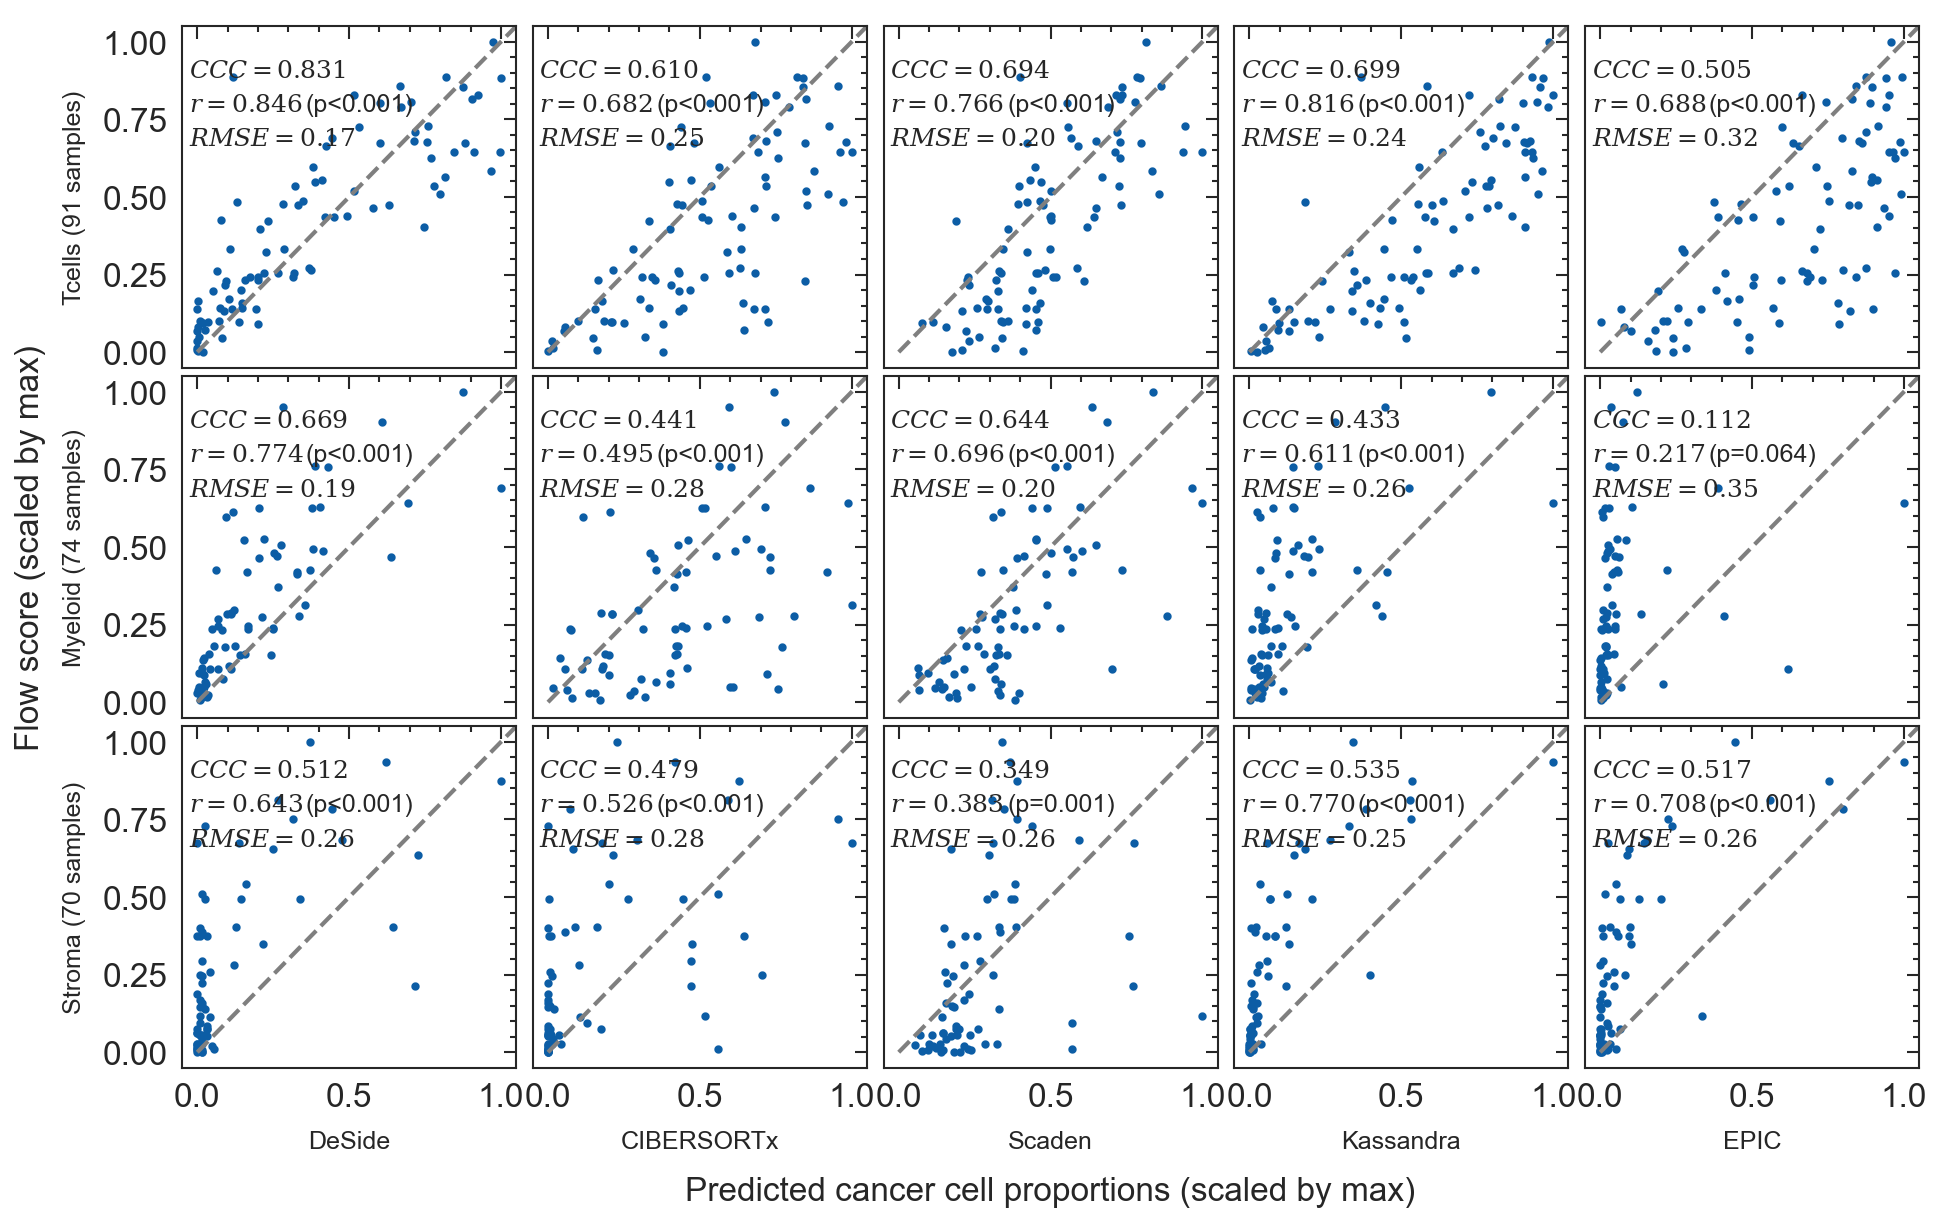

In [30]:
algos = ['DeSide', 'CIBERSORTx', 'Scaden', 'Kassandra', 'EPIC']
predicted_results = {'DeSide': pred_cell_frac_deside, 'CIBERSORTx': pred_cell_frac_cibx, 'Scaden': pred_cell_frac_scaden, 
                     'Kassandra': pred_cell_frac_ka, 'EPIC': pred_cell_frac_epic}
rescaling_score = True
fig, axes = plt.subplots(3, 5, sharex=True, sharey=True, figsize=(7, 4.5))
ccc_values2 = {}
for i in range(3):  # rows
    for j in range(5):
        show_ylabel = False
        if j == 0:
            show_ylabel = True
        current_algo = algos[j]
        current_result = predicted_results[current_algo]
        # i2cols = {0: ('Tcell', 'Tcells'), 1: ('Myeloid', 'Myeloid'), 2: ('Stroma', 'Stroma'), 3: ('Fib', 'Stroma')}
        i2cols = {0: ('Tcell', 'Tcells'), 1: ('Myeloid', 'Myeloid'), 2: ('Fib', 'Stroma')}
        if current_algo == 'Scaden':
            # i2cols = {0: ('Tcell', 'Tcells'), 1: ('Myeloid', 'Myeloid'), 2: ('Fibroblast', 'Stroma'), 3: ('Fibroblast', 'Stroma')}
            i2cols = {0: ('Tcell', 'Tcells'), 1: ('Myeloid', 'Myeloid'), 2: ('Fibroblast', 'Stroma')}
        elif current_algo == 'Kassandra':
            # i2cols = {0: ('T_cells', 'Tcells'), 1: ('Myeloid', 'Myeloid'), 2: ('Stromal_cells', 'Stroma'), 3: ('Fibroblasts', 'Stroma')}
            i2cols = {0: ('T_cells', 'Tcells'), 1: ('Myeloid', 'Myeloid'), 2: ('Fibroblasts', 'Stroma')}
        elif current_algo == 'CIBERSORTx':
            # i2cols = {0: ('Tcell', 'Tcells'), 1: ('Myeloid', 'Myeloid'), 2: ('Stroma', 'Stroma'), 3: ('Fibroblast', 'Stroma')}
            i2cols = {0: ('Tcell', 'Tcells'), 1: ('Myeloid', 'Myeloid'), 2: ('Fibroblast', 'Stroma')}
        elif current_algo == 'EPIC':
            i2cols = {0: ('Tcell', 'Tcells'), 1: ('Myeloid', 'Myeloid'), 2: ('Fibroblast', 'Stroma')}

        if i <= 1:
            ax, ccc = plot_single_ax(ax=axes[i, j], cols=i2cols[i], pred_cell_frac=current_result, flow_score=flow_score, plot_diag=True, remove_outlier=('Stroma', 50),
                           algo=current_algo, show_ylabel=show_ylabel, non_epi_samples=non_epi_samples.index.to_list(), rescaling_score=rescaling_score)
        else:
            ax, ccc = plot_single_ax(ax=axes[i, j], cols=i2cols[i], pred_cell_frac=current_result, flow_score=flow_score, plot_diag=True, remove_outlier=('Stroma', 50), 
                           show_ylabel=show_ylabel, algo=current_algo, show_xlabel=True, non_epi_samples=non_epi_samples.index.to_list(), rescaling_score=rescaling_score)
        ccc_values2[(current_algo, i2cols[i][1], i2cols[i][0])] = ccc

# add a big axis, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel('Predicted cancer cell proportions (scaled by max)', labelpad=15)
if rescaling_score:
    plt.ylabel("Flow score (scaled by max)", labelpad=18)
else:
    plt.ylabel("Flow score (scaled by max)", labelpad=18)

plt.tight_layout(h_pad=0.1, w_pad=0.5)
plt.savefig(os.path.join(fig_dir, 'r-sec5-1_table2_scatter_update.svg'), dpi=300)

In [31]:
ccc_values_gse = pd.DataFrame.from_dict(ccc_values2, orient='index', columns=['CCC'])
ccc_values_gse = ccc_values_gse.reset_index()
# ccc_values_gse.loc[15] = [('Scaden', 'Stroma', 'Stroma')] + ccc_values_gse.loc[10].to_list()[1:]
ccc_values_gse['algo'] = ccc_values_gse['index'].map(lambda x: x[0])
ccc_values_gse['cell_type'] = ccc_values_gse['index'].map(lambda x: 'Fibroblast' if 'Fib' in x[2] else x[1])
ccc_values_gse

,index,CCC,algo,cell_type
0,"(DeSide, Tcells, Tcell)",0.831029,DeSide,Tcells
1,"(CIBERSORTx, Tcells, Tcell)",0.610238,CIBERSORTx,Tcells
2,"(Scaden, Tcells, Tcell)",0.693588,Scaden,Tcells
3,"(Kassandra, Tcells, T_cells)",0.698877,Kassandra,Tcells
4,"(EPIC, Tcells, Tcell)",0.505394,EPIC,Tcells
5,"(DeSide, Myeloid, Myeloid)",0.668777,DeSide,Myeloid
6,"(CIBERSORTx, Myeloid, Myeloid)",0.441471,CIBERSORTx,Myeloid
7,"(Scaden, Myeloid, Myeloid)",0.643775,Scaden,Myeloid
8,"(Kassandra, Myeloid, Myeloid)",0.432696,Kassandra,Myeloid
9,"(EPIC, Myeloid, Myeloid)",0.112118,EPIC,Myeloid


In [32]:
ccc_values_gse.loc[10].to_list()[1:]

[0.5124186364573902, 'DeSide', 'Fibroblast']

In [33]:
color = [sns.color_palette("Paired")[i] for i in [1, 11, 7, 3, 5]]
sns.color_palette(color)

[(0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 (0.6941176470588235, 0.34901960784313724, 0.1568627450980392),
 (1.0, 0.4980392156862745, 0.0),
 (0.2, 0.6274509803921569, 0.17254901960784313),
 (0.8901960784313725, 0.10196078431372549, 0.10980392156862745)]

In [34]:
pred_cell_frac_deside.shape, pred_cell_frac_ka.shape, pred_cell_frac_cibx.shape, pred_cell_frac_scaden.shape, pred_cell_frac_epic.shape

((224, 21), (260, 23), (224, 16), (224, 9), (260, 11))

In [35]:
pred_cell_frac_deside.head(2)

,Plasma B cells,Non-plasma B cells,CD4 T,CD8 T effector,CD8 T (GZMK high),Double-neg-like T,DC,Endothelial Cells,CAFs,Myofibroblasts,...,Mast Cells,NK,Neutrophils,Monocytes,1-others,Cancer Cells,Tcell,Myeloid,Stroma,Fib
IPICRC058.T1,0.001,0.010,0.111,0.240,0.025,0.000,0.052,0.001,0.0,0.0,...,0.002,0.021,0.408,0.012,0.107,0.107,0.376,0.076,0.001,0.0
IPICRC060.T1,0.012,0.013,0.022,0.007,0.000,0.061,0.019,0.000,0.0,0.0,...,0.008,0.000,0.018,0.000,0.837,0.837,0.090,0.021,0.000,0.0


In [36]:
dataset_info.shape

(260, 13)

In [37]:
len([i for i in pred_cell_frac_deside.index if i in dataset_info.index])

223

In [38]:
dataset_info.head(2)

,indication,Gender,Race,Ethnicity,BMI,Age,Pathologic T Stage,Pathologic N Stage,Pathologic M Stage,Grade,Histology,Tumor type,Extraction Site
Sample,,,,,,,,,,,,,
IPIBLAD005.T1,BLAD,Male,White,Non Hispanic or Latino,21.0,77.0,3b,NaN,0,G3: Poorly differentiated (high grade),"Carcinoma, NOS",Primary,Bladder
IPIBLAD006.T1,BLAD,Male,Asian,Non Hispanic or Latino,23.0,65.0,4a,2,NaN,G3: Poorly differentiated (high grade),Not Available,Primary,Bladder


In [39]:
dataset_info.loc[dataset_info.index.isin(pred_cell_frac_deside.index), :].groupby(['indication']).count()

,Gender,Race,Ethnicity,BMI,Age,Pathologic T Stage,Pathologic N Stage,Pathologic M Stage,Grade,Histology,Tumor type,Extraction Site
indication,,,,,,,,,,,,
BLAD,14,14,14,14,14,14,13,2,14,14,14,13
CRC,27,27,27,27,27,26,27,13,27,27,26,24
GBM,1,1,1,1,1,1,1,1,1,1,1,1
GYN,43,43,43,43,43,43,43,11,43,43,43,37
HEP,6,6,6,6,6,6,6,1,6,6,6,5
HNSC,21,21,21,21,21,21,21,17,21,21,21,20
KID,47,47,47,47,47,47,47,5,47,47,46,47
LUNG,27,27,27,27,27,27,26,2,27,27,27,24
MEL,22,21,21,21,21,21,21,20,21,21,20,20


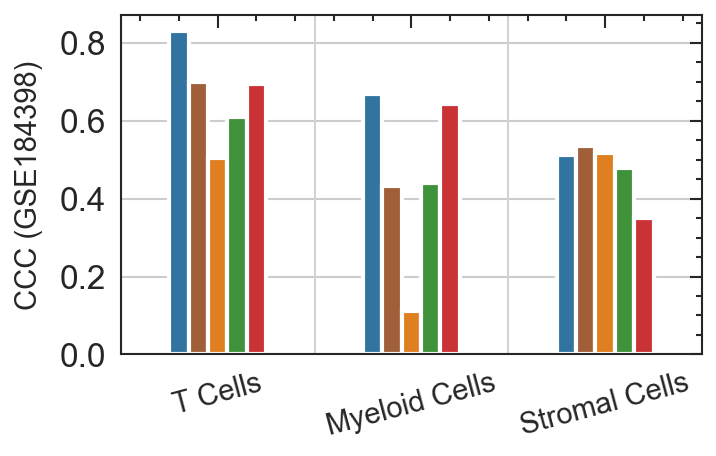

In [40]:
# fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(7, 4))
fig, ax1 = plt.subplots(figsize=(2.5, 1.5))
width = 0.5
# g1 = sns.barplot(data=ccc_values_gse, x='cell_type', y='CCC', hue='algo', ax=ax1, width=width, 
                 # order=['Tcells', 'Myeloid', 'Stroma', 'Fibroblast'], hue_order=['DeSide', 'CIBERSORT', 'Scaden', 'Kassandra'], palette=color)
g1 = sns.barplot(data=ccc_values_gse, x='cell_type', y='CCC', hue='algo', ax=ax1, width=width, 
                 order=['Tcells', 'Myeloid', 'Fibroblast'], hue_order=['DeSide', 'Kassandra', 'EPIC', 'CIBERSORTx', 'Scaden'], palette=color)
g1.legend([],[], frameon=False)

# sns.move_legend(g1, "upper left", bbox_to_anchor=(1, 1), ncol=1, title=None, frameon=False, fontsize=6, borderpad=0, handletextpad=0)
ax1.grid(axis='y')
for _x in range(3):
    ax1.axvline(_x - 0.5, color='lightgray', linewidth=0.5)
for item in g1.get_xticklabels():
    item.set_rotation(15)
# ax1.legend(fontsize=5, loc='best', ncol=2)
# ax1.set_yticks([0.0, 0.2, 0.4, 0.6])
# ax1.set_xticks(range(4), ['Tcells', 'Myeloid', 'Stroma\n(Fib.+Endo.)', 'Stroma\n(Fib.)'])
ax1.set_xticks(range(3), ['T Cells', 'Myeloid Cells', 'Stromal Cells'], fontsize=7)
ax1.set_xlabel('')
ax1.set_ylabel('CCC ' + '(' + f'GSE184398' + ')', fontsize=7)

plt.savefig(os.path.join(fig_dir, 'r-sec5-1_table2_bar_update.svg'), dpi=300)

---
## 2. Other test sets
- from  https://science.bostongene.com/kassandra/downloads

In [41]:
algo2cell_type_name_mapping = {
        'CIBERSORTx_HNSCC': {'B cell': 'B Cells', 'T cells CD4': 'CD4 T', 'T cells CD8': 'CD8 T', 'Dendritic': 'DC',
                            'Malignant': 'Cancer Cells', 'Endothelial': 'Endothelial Cells',
                            'Fibroblast': 'Fibroblasts', 'Macrophage': 'Macrophages', 'Mast': 'Mast Cells',
                            },
        'EPIC_TRef': {'B.cells': 'B Cells', 'CD4.T': 'CD4 T', 'CD8.T': 'CD8 T',
                      'otherCells': 'Cancer Cells', 'Endothelial.Cells': 'Endothelial Cells',
                      'Fibroblasts': 'Fibroblasts',  'NK': 'NK', 'Macrophages': 'Macrophages',
                      },
        'Scaden_ascites': {'CD4Tcells': 'CD4 T', 'CD8Tcells': 'CD8 T', 'Carcinoma': 'Cancer Cells',
                           'DC': 'DC', 'Fibroblast': 'Fibroblasts', 'NK': 'NK',
                          },
        'Kassandra_self': {'B_cells': 'B Cells', 'CD4_T_cells': 'CD4 T', 'CD8_T_cells': 'CD8 T',
                           'Endothelium': 'Endothelial Cells', 'Fibroblasts': 'Fibroblasts', 'Macrophages': 'Macrophages',
                           'NK_cells': 'NK', 'Neutrophils': 'Neutrophils', 'Other': 'Cancer Cells'},
}

### Merged predicted cell prop.

In [42]:
ind_ds_dir = '../datasets/Independent_Test_Set/to_xiongxin/'
cell_prop_pred = pd.read_csv(os.path.join(ind_ds_dir, 'validation_datasets_predicted_by_algorithms/predicted_by_algorithms/cell_propotion_with_four_datasets.csv'), index_col=0)
cell_prop_pred.loc[cell_prop_pred['cell_proportion'] < 0, 'cell_proportion'] = 0
cell_prop_pred.loc[cell_prop_pred['cell_proportion'] > 100, 'cell_proportion'] = 100
# remove CIBERSORT and fardeep_relative since the sum != 100
cell_prop_pred = cell_prop_pred.loc[~cell_prop_pred['algo'].isin(['CIBERSORT', 'fardeep_relative', 'Scaden_PBMC']), :].copy()
print(cell_prop_pred)

           sample_id             algo           cell_type  cell_proportion  \
0      Sample_1976.0             ABIS      Plasma B cells         0.096500   
1      Sample_1976.0             ABIS  Non-plasma B cells         0.057000   
2      Sample_1976.0             ABIS             B Cells         0.153500   
3      Sample_1976.0             ABIS               CD4 T         0.000000   
4      Sample_1976.0             ABIS               CD8 T         0.000000   
...              ...              ...                 ...              ...   
16245     SRR8030956  quantiseq_tumor             T Cells         2.183436   
16246     SRR8030956  quantiseq_tumor         Macrophages         3.835966   
16247     SRR8030956  quantiseq_tumor               CD4 T         0.994895   
16248     SRR8030956  quantiseq_tumor         Lymphocytes         4.863905   
16249     SRR8030956  quantiseq_tumor        Cancer Cells        90.498269   

                datasets  
0      SC_ovarian_cancer  
1      SC

In [43]:
cell_prop_pred['algo'].unique()

array(['ABIS', 'DeSide', 'EPIC_BRef', 'EPIC_TRef', 'fardeep_absolute',
       'HNSC_matrix_with_BC_CIBERSORTX', 'Kassandra',
       'LM22_matrix_with_BC_CIBERSORTX', 'quantiseq', 'quantiseq_tumor'],
      dtype=object)

In [44]:
cell_prop_pred['datasets'].unique()

array(['SC_ovarian_cancer', 'SC_glioblastoma', 'SC_HNSCC', 'GSE121127'],
      dtype=object)

#### Predicted cell prop. by Scaden
- The provided results for Scaden is not complete by above downloaded dataset, so we calculated for these 3 datasets using Scaden (ascites) locally 

In [45]:
pred_dir = os.path.join(ind_ds_dir, 'validation_datasets_expression')
ds2file_name = {'SC_glioblastoma': 'scaden_ascites_pred_cell_prop_sc_glioblastoma.txt', 'SC_HNSCC': 'scaden_ascites_pred_cell_prop_sc_hnscc.txt', 
                'SC_ovarian_cancer': 'scaden_ascites_pred_cell_prop_sc_overian.txt'}
cell_prop_pred_scaden = []
for ds, file in ds2file_name.items():
    current_result = pd.read_csv(os.path.join(pred_dir, file), index_col=0, sep='\t')
    current_result['datasets'] = ds
    print(ds, current_result.shape)
    cell_prop_pred_scaden.append(current_result)
cell_prop_pred_scaden_df = pd.concat(cell_prop_pred_scaden)
cell_prop_pred_scaden_df['algo'] = 'Scaden_ascites'
name_mapping = algo2cell_type_name_mapping['Scaden_ascites']
name_mapping['index'] = 'sample_id'
cell_prop_pred_scaden_df.reset_index(inplace=True)
cell_prop_pred_scaden_df.rename(columns=name_mapping, inplace=True)
cell_prop_pred_scaden_df['T Cells'] = cell_prop_pred_scaden_df.loc[:, ['CD4 T', 'CD8 T']].sum(axis=1)
print(cell_prop_pred_scaden_df.head(2))
cell_prop_pred_scaden_df['Lymphocytes'] = cell_prop_pred_scaden_df.loc[:, ['T Cells', 'NK']].sum(axis=1)
cell_prop_pred_scaden_df['Macrophages'] = cell_prop_pred_scaden_df['Monocytes'].copy()
print_df(cell_prop_pred_scaden_df)

SC_glioblastoma (28, 8)
SC_HNSCC (22, 8)
SC_ovarian_cancer (8, 8)
  sample_id     CD8 T  Monocytes  Cancer Cells        NK        DC     CD4 T  \
0    BT1160  0.064242   0.028067      0.343179  0.091911  0.094807  0.228585   
1    BT1187  0.016600   0.872636      0.011351  0.027116  0.027774  0.037215   

   Fibroblasts         datasets            algo   T Cells  
0     0.149208  SC_glioblastoma  Scaden_ascites  0.292827  
1     0.007307  SC_glioblastoma  Scaden_ascites  0.053816  
  >>  <<  
(58, 13)
  sample_id     CD8 T  Monocytes  Cancer Cells        NK        DC     CD4 T  \
0    BT1160  0.064242   0.028067      0.343179  0.091911  0.094807  0.228585   
1    BT1187  0.016600   0.872636      0.011351  0.027116  0.027774  0.037215   

   Fibroblasts         datasets            algo   T Cells  Lymphocytes  \
0     0.149208  SC_glioblastoma  Scaden_ascites  0.292827     0.384738   
1     0.007307  SC_glioblastoma  Scaden_ascites  0.053816     0.080931   

   Macrophages  
0     0.0280

In [46]:
cell_prop_pred_scaden_df.head(2)

,sample_id,CD8 T,Monocytes,Cancer Cells,NK,DC,CD4 T,Fibroblasts,datasets,algo,T Cells,Lymphocytes,Macrophages
0,BT1160,0.064242,0.028067,0.343179,0.091911,0.094807,0.228585,0.149208,SC_glioblastoma,Scaden_ascites,0.292827,0.384738,0.028067
1,BT1187,0.016600,0.872636,0.011351,0.027116,0.027774,0.037215,0.007307,SC_glioblastoma,Scaden_ascites,0.053816,0.080931,0.872636


In [47]:
cell_types = [
    'CD8 T',
    'Monocytes',
    'Cancer Cells',
    'NK',
    'DC',
    'CD4 T',
    'Fibroblasts',
    'T Cells',
    'Lymphocytes',
    'Macrophages',
]
cell_prop_pred_scaden_list = []
for ct in cell_types:
    current_part = cell_prop_pred_scaden_df.loc[:, ['sample_id', 'datasets', 'algo']].copy()
    current_part['cell_type'] = ct
    current_part['cell_proportion'] = cell_prop_pred_scaden_df.loc[:, ct].copy()
    cell_prop_pred_scaden_list.append(current_part)
cell_prop_pred_scaden_df_long = pd.concat(cell_prop_pred_scaden_list)
print_df(cell_prop_pred_scaden_df_long)

  >>  <<  
(580, 5)
  sample_id         datasets            algo cell_type  cell_proportion
0    BT1160  SC_glioblastoma  Scaden_ascites     CD8 T         0.064242
1    BT1187  SC_glioblastoma  Scaden_ascites     CD8 T         0.016600


In [48]:
cell_prop_pred_new = pd.concat([cell_prop_pred, cell_prop_pred_scaden_df_long])
print_df(cell_prop_pred_new)

  >>  <<  
(14512, 5)
       sample_id  algo           cell_type  cell_proportion           datasets
0  Sample_1976.0  ABIS      Plasma B cells           0.0965  SC_ovarian_cancer
1  Sample_1976.0  ABIS  Non-plasma B cells           0.0570  SC_ovarian_cancer


In [49]:
cell_prop_pred_new['algo'].unique()

array(['ABIS', 'DeSide', 'EPIC_BRef', 'EPIC_TRef', 'fardeep_absolute',
       'HNSC_matrix_with_BC_CIBERSORTX', 'Kassandra',
       'LM22_matrix_with_BC_CIBERSORTX', 'quantiseq', 'quantiseq_tumor',
       'Scaden_ascites'], dtype=object)

### Dataset SC_glioblastoma

In [50]:
ds2 = 'SC_glioblastoma'
cell_prop_true = pd.read_csv(f'{ind_ds_dir}/validation_datasets_cell_values/cell_values/{ds2}.csv', index_col=0)
print_df(cell_prop_true)

  >>  <<  
(3, 28)
              BT1160     BT1187      BT749      BT771      BT786  BT830  \
Macrophages        0  89.954338   0.000000   2.064897   0.471698      0   
Cancer Cells     100   3.652968  99.369085  96.755162  98.584906    100   

                   BT85      BT920  MGH100  MGH101  ...     MGH122     MGH124  \
Macrophages    0.000000   4.318937       0    23.5  ...  17.948718  11.351351   
Cancer Cells  99.591837  95.681063     100    76.5  ...  73.260073  88.378378   

                 MGH125     MGH128     MGH129     MGH136     MGH143  \
Macrophages   10.025063   0.000000   0.000000   0.000000   0.000000   
Cancer Cells  83.208020  86.413043  98.958333  99.134199  99.635036   

                 MGH151     MGH152      MGH66  
Macrophages    0.000000   0.000000   0.229358  
Cancer Cells  74.233129  99.563319  99.770642  

[2 rows x 28 columns]


In [51]:
cell_prop_true = cell_prop_true / 100

In [52]:
cell_prop_true.index.unique()

Index(['Macrophages', 'Cancer Cells', 'T Cells'], dtype='object')

In [53]:
cell_prop_pred_sc_gliob = cell_prop_pred_new.loc[cell_prop_pred_new['datasets'] == ds2, :].copy()
print_df(cell_prop_pred_sc_gliob)

  >>  <<  
(3332, 5)
   sample_id  algo           cell_type  cell_proportion         datasets
96    BT1160  ABIS      Plasma B cells            0.254  SC_glioblastoma
97    BT1160  ABIS  Non-plasma B cells            0.000  SC_glioblastoma


In [54]:
cell_prop_pred_sc_gliob['cell_type'].unique()

array(['Plasma B cells', 'Non-plasma B cells', 'B Cells', 'CD4 T',
       'CD8 T', 'T Cells', 'DC', 'NK', 'Neutrophils', 'Monocytes',
       'Lymphocytes', 'Cancer Cells', 'Endothelial Cells', 'Macrophages',
       'Mast Cells', 'Fibroblasts', 'CAFs', 'Myofibroblasts'],
      dtype=object)

In [55]:
algo_ct2ccc = {}
for (algo, cell_type), group in cell_prop_pred_sc_gliob.groupby(['algo', 'cell_type']):
    if cell_type in cell_prop_true.index:
        group['cell_proportion_pred'] = group['cell_proportion']
        if algo not in ['DeSide', 'Scaden_ascites']:
            group['cell_proportion_pred'] = group['cell_proportion'] / 100
        group = group.set_index('sample_id')
        current_true = cell_prop_true.T.loc[:, [cell_type]].copy()
        # print(current_true)
        group_new = current_true.join(group, how='inner')
        print(algo, cell_type, group_new.shape)
        # print(group_new)
        algo_ct2ccc[(algo, cell_type)] = get_ccc(group_new[cell_type], group_new['cell_proportion_pred'])
algo_ct2ccc_df_ds2 = pd.DataFrame.from_dict(algo_ct2ccc, orient='index', columns=['CCC'])
# algo_ct2ccc_df = algo_ct2ccc_df.reset_index()
algo_ct2ccc_df_ds2['Algorithm'] = algo_ct2ccc_df_ds2.index.map(lambda x: x[0].replace('_matrix_with_BC', ''))
algo_ct2ccc_df_ds2['Cell type'] = algo_ct2ccc_df_ds2.index.map(lambda x: x[1])
print_df(algo_ct2ccc_df_ds2)

ABIS Cancer Cells (28, 6)
ABIS T Cells (28, 6)
DeSide Cancer Cells (28, 6)
DeSide Macrophages (28, 6)
DeSide T Cells (28, 6)
EPIC_BRef Cancer Cells (28, 6)
EPIC_BRef T Cells (28, 6)
EPIC_TRef Cancer Cells (28, 6)
EPIC_TRef Macrophages (28, 6)
EPIC_TRef T Cells (28, 6)
HNSC_matrix_with_BC_CIBERSORTX Cancer Cells (28, 6)
HNSC_matrix_with_BC_CIBERSORTX Macrophages (28, 6)
HNSC_matrix_with_BC_CIBERSORTX T Cells (28, 6)
Kassandra Cancer Cells (28, 6)
Kassandra Macrophages (28, 6)
Kassandra T Cells (28, 6)
LM22_matrix_with_BC_CIBERSORTX Cancer Cells (28, 6)
LM22_matrix_with_BC_CIBERSORTX Macrophages (28, 6)
LM22_matrix_with_BC_CIBERSORTX T Cells (28, 6)
Scaden_ascites Cancer Cells (28, 6)
Scaden_ascites Macrophages (28, 6)
Scaden_ascites T Cells (28, 6)
quantiseq Cancer Cells (28, 6)
quantiseq Macrophages (28, 6)
quantiseq T Cells (28, 6)
quantiseq_tumor Cancer Cells (28, 6)
quantiseq_tumor Macrophages (28, 6)
quantiseq_tumor T Cells (28, 6)
  >>  <<  
(28, 3)
                           CCC 

### Dataset SC_HNSCC

In [56]:
ds3 = 'SC_HNSCC'
cell_prop_true = pd.read_csv(f'{ind_ds_dir}/validation_datasets_cell_values/cell_values/{ds3}.csv', index_col=0)
print_df(cell_prop_true)

  >>  <<  
(14, 22)
       lymph_node_20  lymph_node_25  lymph_node_26  lymph_node_28  \
CD4 T            0.0      22.068966       0.350877       0.823045   
DC               0.0       0.689655       0.701754       0.000000   

       lymph_node_5  primary_10  primary_12  primary_13  primary_16  \
CD4 T           0.0    2.298851   48.630137    9.756098   31.578947   
DC              0.0    0.000000    0.000000   36.585366    1.228070   

       primary_17  ...  primary_22  primary_23  primary_24  primary_25  \
CD4 T     13.4375  ...    0.000000   47.058824    0.813008   11.325301   
DC         0.0000  ...    0.507614    0.000000    0.000000    1.686747   

       primary_26  primary_28  primary_5  primary_6  primary_7  primary_8  
CD4 T    1.587302         0.0   5.714286        0.0        0.0  18.811881  
DC       0.793651         0.0   0.000000        0.0        0.0   0.000000  

[2 rows x 22 columns]


In [57]:
cell_prop_true = cell_prop_true / 100

In [58]:
cell_prop_true.index.unique()

Index(['CD4 T', 'DC', 'Endothelial Cells', 'Fibroblasts', 'Macrophages',
       'Mast_cells', 'Myofibroblasts', 'Non-plasma B cells', 'Plasma B cells',
       'Cancer Cells', 'CD8 T', 'T Cells', 'B Cells', 'Lymphocytes'],
      dtype='object')

In [59]:
cell_prop_pred_sc_hnscc = cell_prop_pred_new.loc[cell_prop_pred_new['datasets'] == ds3, :].copy()
print_df(cell_prop_pred_sc_hnscc)

  >>  <<  
(2904, 5)
         sample_id  algo           cell_type  cell_proportion  datasets
432  lymph_node_20  ABIS      Plasma B cells             0.42  SC_HNSCC
433  lymph_node_20  ABIS  Non-plasma B cells             0.00  SC_HNSCC


In [60]:
cell_prop_pred_sc_hnscc['cell_type'].unique()

array(['Plasma B cells', 'Non-plasma B cells', 'B Cells', 'CD4 T',
       'CD8 T', 'T Cells', 'DC', 'NK', 'Neutrophils', 'Monocytes',
       'Lymphocytes', 'Cancer Cells', 'Endothelial Cells', 'Macrophages',
       'Mast Cells', 'Fibroblasts', 'CAFs', 'Myofibroblasts'],
      dtype=object)

In [61]:
algo_ct2ccc = {}
for (algo, cell_type), group in cell_prop_pred_sc_hnscc.groupby(['algo', 'cell_type']):
    if cell_type in cell_prop_true.index:
        group['cell_proportion_pred'] = group['cell_proportion']
        if algo not in ['DeSide', 'Scaden_ascites']:
            group['cell_proportion_pred'] = group['cell_proportion'] / 100
        group = group.set_index('sample_id')
        current_true = cell_prop_true.T.loc[:, [cell_type]].copy()
        # print(current_true)
        group_new = current_true.join(group, how='inner')
        print(algo, cell_type, group_new.shape)
        # print(group_new)
        algo_ct2ccc[(algo, cell_type)] = get_ccc(group_new[cell_type], group_new['cell_proportion_pred'])
algo_ct2ccc_df_ds3 = pd.DataFrame.from_dict(algo_ct2ccc, orient='index', columns=['CCC'])
# algo_ct2ccc_df = algo_ct2ccc_df.reset_index()
algo_ct2ccc_df_ds3['Algorithm'] = algo_ct2ccc_df_ds3.index.map(lambda x: x[0].replace('_matrix_with_BC', ''))
algo_ct2ccc_df_ds3['Cell type'] = algo_ct2ccc_df_ds3.index.map(lambda x: x[1])
print_df(algo_ct2ccc_df_ds3)

ABIS B Cells (22, 6)
ABIS CD4 T (22, 6)
ABIS CD8 T (22, 6)
ABIS Cancer Cells (22, 6)
ABIS DC (22, 6)
ABIS Lymphocytes (22, 6)
ABIS Non-plasma B cells (22, 6)
ABIS Plasma B cells (22, 6)
ABIS T Cells (22, 6)
DeSide B Cells (22, 6)
DeSide CD4 T (22, 6)
DeSide CD8 T (22, 6)
DeSide Cancer Cells (22, 6)
DeSide DC (22, 6)
DeSide Endothelial Cells (22, 6)
DeSide Fibroblasts (22, 6)
DeSide Lymphocytes (22, 6)
DeSide Macrophages (22, 6)
DeSide Myofibroblasts (22, 6)
DeSide Non-plasma B cells (22, 6)
DeSide Plasma B cells (22, 6)
DeSide T Cells (22, 6)
EPIC_BRef B Cells (22, 6)
EPIC_BRef CD4 T (22, 6)
EPIC_BRef CD8 T (22, 6)
EPIC_BRef Cancer Cells (22, 6)
EPIC_BRef Lymphocytes (22, 6)
EPIC_BRef T Cells (22, 6)
EPIC_TRef B Cells (22, 6)
EPIC_TRef CD4 T (22, 6)
EPIC_TRef CD8 T (22, 6)
EPIC_TRef Cancer Cells (22, 6)
EPIC_TRef Endothelial Cells (22, 6)
EPIC_TRef Fibroblasts (22, 6)
EPIC_TRef Lymphocytes (22, 6)
EPIC_TRef Macrophages (22, 6)
EPIC_TRef T Cells (22, 6)
HNSC_matrix_with_BC_CIBERSORTX B 

### Dataset SC_ovarian_cancer

In [62]:
ds4 = 'SC_ovarian_cancer'
cell_prop_true = pd.read_csv(f'{ind_ds_dir}/validation_datasets_cell_values/cell_values/{ds4}.csv', index_col=0)
print_df(cell_prop_true)

  >>  <<  
(7, 8)
         Sample_1976.0  Sample_3250.0  Sample_3250.1  Sample_3266.0  \
B Cells       0.282486            0.0       1.070664      43.618340   
DC            3.389831            0.0       0.000000       9.913259   

         Sample_3281.0  Sample_3288.0  Sample_3288.1  Sample_3290.0  
B Cells            0.0            0.0       0.020437       0.085397  
DC                 0.0            0.0       0.000000       0.000000  


In [63]:
cell_prop_true = cell_prop_true / 100

In [64]:
cell_prop_true.index.unique()

Index(['B Cells', 'DC', 'Fibroblasts', 'Macrophages', 'NK', 'T Cells',
       'Cancer Cells'],
      dtype='object')

In [65]:
cell_prop_pred_sc_ovarian = cell_prop_pred_new.loc[cell_prop_pred_new['datasets'] == ds4, :].copy()
print_df(cell_prop_pred_sc_ovarian)

  >>  <<  
(1056, 5)
       sample_id  algo           cell_type  cell_proportion           datasets
0  Sample_1976.0  ABIS      Plasma B cells           0.0965  SC_ovarian_cancer
1  Sample_1976.0  ABIS  Non-plasma B cells           0.0570  SC_ovarian_cancer


In [66]:
cell_prop_pred_sc_ovarian['cell_type'].unique()

array(['Plasma B cells', 'Non-plasma B cells', 'B Cells', 'CD4 T',
       'CD8 T', 'T Cells', 'DC', 'NK', 'Neutrophils', 'Monocytes',
       'Lymphocytes', 'Cancer Cells', 'Endothelial Cells', 'Macrophages',
       'Mast Cells', 'Fibroblasts', 'CAFs', 'Myofibroblasts'],
      dtype=object)

In [67]:
algo_ct2ccc = {}
for (algo, cell_type), group in cell_prop_pred_sc_ovarian.groupby(['algo', 'cell_type']):
    if cell_type in cell_prop_true.index:
        group['cell_proportion_pred'] = group['cell_proportion']
        if algo not in ['DeSide', 'Scaden_ascites']:
            group['cell_proportion_pred'] = group['cell_proportion'] / 100
        group = group.set_index('sample_id')
        current_true = cell_prop_true.T.loc[:, [cell_type]].copy()
        # print(current_true)
        group_new = current_true.join(group, how='inner')
        print(algo, cell_type, group_new.shape)
        # print(group_new)
        algo_ct2ccc[(algo, cell_type)] = get_ccc(group_new[cell_type], group_new['cell_proportion_pred'])
algo_ct2ccc_df_ds4 = pd.DataFrame.from_dict(algo_ct2ccc, orient='index', columns=['CCC'])
# algo_ct2ccc_df = algo_ct2ccc_df.reset_index()
algo_ct2ccc_df_ds4['Algorithm'] = algo_ct2ccc_df_ds4.index.map(lambda x: x[0].replace('_matrix_with_BC', ''))
algo_ct2ccc_df_ds4['Cell type'] = algo_ct2ccc_df_ds4.index.map(lambda x: x[1])
print_df(algo_ct2ccc_df_ds4)

ABIS B Cells (8, 6)
ABIS Cancer Cells (8, 6)
ABIS DC (8, 6)
ABIS NK (8, 6)
ABIS T Cells (8, 6)
DeSide B Cells (8, 6)
DeSide Cancer Cells (8, 6)
DeSide DC (8, 6)
DeSide Fibroblasts (8, 6)
DeSide Macrophages (8, 6)
DeSide NK (8, 6)
DeSide T Cells (8, 6)
EPIC_BRef B Cells (8, 6)
EPIC_BRef Cancer Cells (8, 6)
EPIC_BRef NK (8, 6)
EPIC_BRef T Cells (8, 6)
EPIC_TRef B Cells (8, 6)
EPIC_TRef Cancer Cells (8, 6)
EPIC_TRef Fibroblasts (8, 6)
EPIC_TRef Macrophages (8, 6)
EPIC_TRef NK (8, 6)
EPIC_TRef T Cells (8, 6)
HNSC_matrix_with_BC_CIBERSORTX B Cells (8, 6)
HNSC_matrix_with_BC_CIBERSORTX Cancer Cells (8, 6)
HNSC_matrix_with_BC_CIBERSORTX DC (8, 6)
HNSC_matrix_with_BC_CIBERSORTX Fibroblasts (8, 6)
HNSC_matrix_with_BC_CIBERSORTX Macrophages (8, 6)
HNSC_matrix_with_BC_CIBERSORTX T Cells (8, 6)
Kassandra B Cells (8, 6)
Kassandra Cancer Cells (8, 6)
Kassandra Fibroblasts (8, 6)
Kassandra Macrophages (8, 6)
Kassandra NK (8, 6)
Kassandra T Cells (8, 6)
LM22_matrix_with_BC_CIBERSORTX B Cells (8, 6)
LM

### Plot

In [68]:
algo_name_mapping = {'HNSC_CIBERSORTX': 'CIBERSORTx_HNSCC'}
algo_ct2ccc_df_ds3['Algorithm'] = algo_ct2ccc_df_ds3['Algorithm'].map(lambda x: algo_name_mapping.get(x, x))
algo_ct2ccc_df_ds3['Algorithm'].unique()

array(['ABIS', 'DeSide', 'EPIC_BRef', 'EPIC_TRef', 'CIBERSORTx_HNSCC',
       'Kassandra', 'LM22_CIBERSORTX', 'Scaden_ascites',
       'fardeep_absolute', 'quantiseq', 'quantiseq_tumor'], dtype=object)

In [69]:
selected_colors = [sns.color_palette("Paired")[i] for i in [1, 11, 7, 3, 5]]  #  [1, 0, 3, 2, 5, 4, 7, 11, 9]
sns.color_palette(selected_colors)

[(0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 (0.6941176470588235, 0.34901960784313724, 0.1568627450980392),
 (1.0, 0.4980392156862745, 0.0),
 (0.2, 0.6274509803921569, 0.17254901960784313),
 (0.8901960784313725, 0.10196078431372549, 0.10980392156862745)]

In [70]:
# algos = ['DeSide', 'Kassandra', 'ABIS', 'fardeep_absolute', 
#          'EPIC_BRef', 'EPIC_TRef',
#          'HNSC_CIBERSORTX', 'LM22_CIBERSORTX', 
#          'quantiseq', 'quantiseq_tumor']
algos = ['DeSide', 'Kassandra', 'EPIC_TRef',
         'CIBERSORTx_HNSCC', 'Scaden_ascites']
algo2color = {algos[i]: selected_colors[i] for i in range(5)}

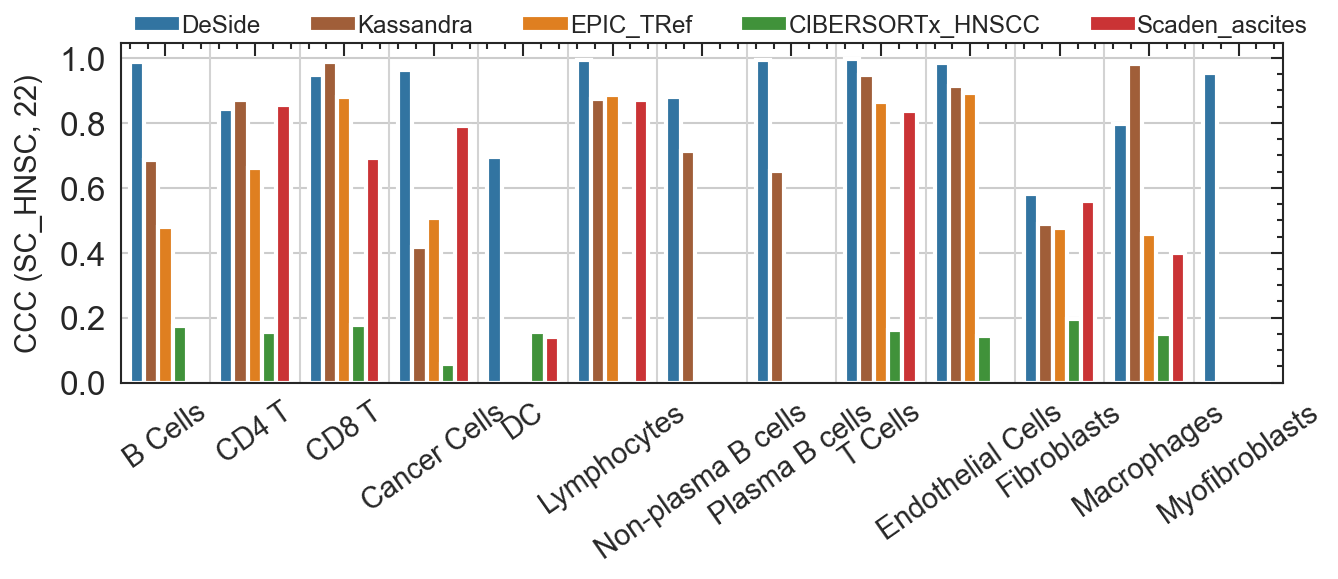

In [71]:
fig, ax1 = plt.subplots(1, 1, figsize=(5, 1.5))

hue_order_ds3 = [i for i in algos if i in algo_ct2ccc_df_ds3['Algorithm'].unique()]
g1 = sns.barplot(algo_ct2ccc_df_ds3, x="Cell type", y="CCC", hue="Algorithm", 
                 palette=[algo2color[algo] for algo in hue_order_ds3], ax=ax1, hue_order=hue_order_ds3)
g1legend = g1.legend()
sns.move_legend(g1, 'upper left',  bbox_to_anchor=(0, 1.12), ncol=5, title=None, frameon=False, fontsize=5.8, borderpad=0, handletextpad=0)
ax1.grid(axis='y')
for _x in range(13):
    ax1.axvline(_x - 0.5, color='lightgray', linewidth=0.5)
g1.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax1.set_xlabel('')
ax1.set_ylabel('')
ax1.tick_params(axis='x', labelrotation=35, labelsize=7)

# add a big axis, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis\n",
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("")
plt.ylabel('CCC ' + '(' + f'SC_HNSC, 22' + ')', fontsize=7)

plt.savefig(os.path.join(fig_dir, 'sc_hnscc_new.svg'), dpi=300)

In [72]:
algo_name_mapping = {'HNSC_CIBERSORTX': 'CIBERSORTx_HNSCC'}
algo_ct2ccc_df_ds2['Algorithm'] = algo_ct2ccc_df_ds2['Algorithm'].map(lambda x: algo_name_mapping.get(x, x))
algo_ct2ccc_df_ds2['Algorithm'].unique()

array(['ABIS', 'DeSide', 'EPIC_BRef', 'EPIC_TRef', 'CIBERSORTx_HNSCC',
       'Kassandra', 'LM22_CIBERSORTX', 'Scaden_ascites', 'quantiseq',
       'quantiseq_tumor'], dtype=object)

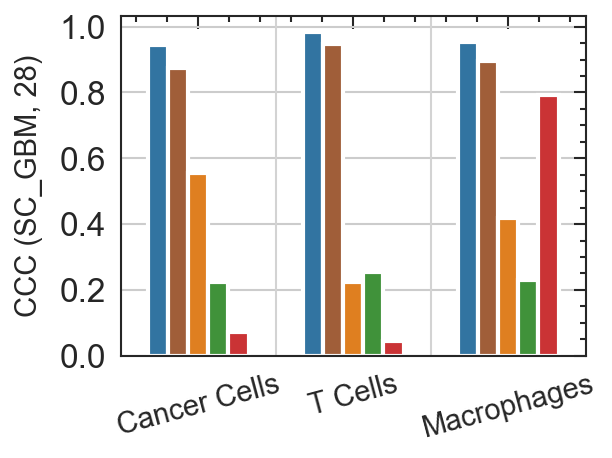

In [73]:
fig, ax5 = plt.subplots(1, 1, figsize=(2., 1.5))
# # ds1
# hue_order_ds1 = [i for i in algos if i in algo_ct2ccc_df_ds1['Algorithm'].unique()]
# g4 = sns.barplot(algo_ct2ccc_df_ds1, x="Cell type", y="CCC", hue="Algorithm", palette=[algo2color[algo] for algo in hue_order_ds1], ax=ax4, hue_order=hue_order_ds1)
# # g4legend = g4.legend()
# # sns.move_legend(g4, 'upper left',  bbox_to_anchor=(1, 1), ncol=2, title=None, frameon=False, fontsize=6, borderpad=0, handletextpad=0)
# g4.legend([], [], frameon=False)
# g4.set_xlabel('')
# g4.set_yticks([0, 0.5, 1])
# g4.set_ylabel(ds1)

# ds2
hue_order_ds2 = [i for i in algos if i in algo_ct2ccc_df_ds2['Algorithm'].unique()]
width = 0.65
g5 = sns.barplot(algo_ct2ccc_df_ds2, x="Cell type", y="CCC", hue="Algorithm", palette=[algo2color[algo] for algo in hue_order_ds2], ax=ax5, hue_order=hue_order_ds2, width=width)
# g5legend = g5.legend()
# sns.move_legend(g5, 'upper left',  bbox_to_anchor=(1, 1), ncol=2, title=None, frameon=False, fontsize=6, borderpad=0, handletextpad=0)
g5.legend([], [], frameon=False)
g5.set_xlabel('')
g5.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
g5.set_ylabel('CCC ' + '(' + 'SC_GBM, 28' + ')', fontsize=7)
ax5.grid(axis='y')
for _x in range(3):
    ax5.axvline(_x - 0.5, color='lightgray', linewidth=0.5)
ax5.tick_params(axis='x', labelrotation=15, labelsize=7)
# ax5.yaxis.set_label_position("right")
# plt.tight_layout()
plt.savefig(os.path.join(fig_dir, 'sc_glioblastoma.svg'), dpi=300)

In [74]:
algo_name_mapping = {'HNSC_CIBERSORTX': 'CIBERSORTx_HNSCC'}
algo_ct2ccc_df_ds4['Algorithm'] = algo_ct2ccc_df_ds4['Algorithm'].map(lambda x: algo_name_mapping.get(x, x))
algo_ct2ccc_df_ds4['Algorithm'].unique()

array(['ABIS', 'DeSide', 'EPIC_BRef', 'EPIC_TRef', 'CIBERSORTx_HNSCC',
       'Kassandra', 'LM22_CIBERSORTX', 'Scaden_ascites',
       'fardeep_absolute', 'quantiseq', 'quantiseq_tumor'], dtype=object)

In [75]:
algo_ct2ccc_df_ds4.head(2)

,CCC,Algorithm,Cell type
"(ABIS, B Cells)",0.171354,ABIS,B Cells
"(ABIS, Cancer Cells)",-0.101440,ABIS,Cancer Cells


In [76]:
algo_ct2ccc_df_ds4 = algo_ct2ccc_df_ds4.loc[algo_ct2ccc_df_ds4['Cell type'] != 'T Cells', :].copy()
algo_ct2ccc_df_ds4.shape

(53, 3)

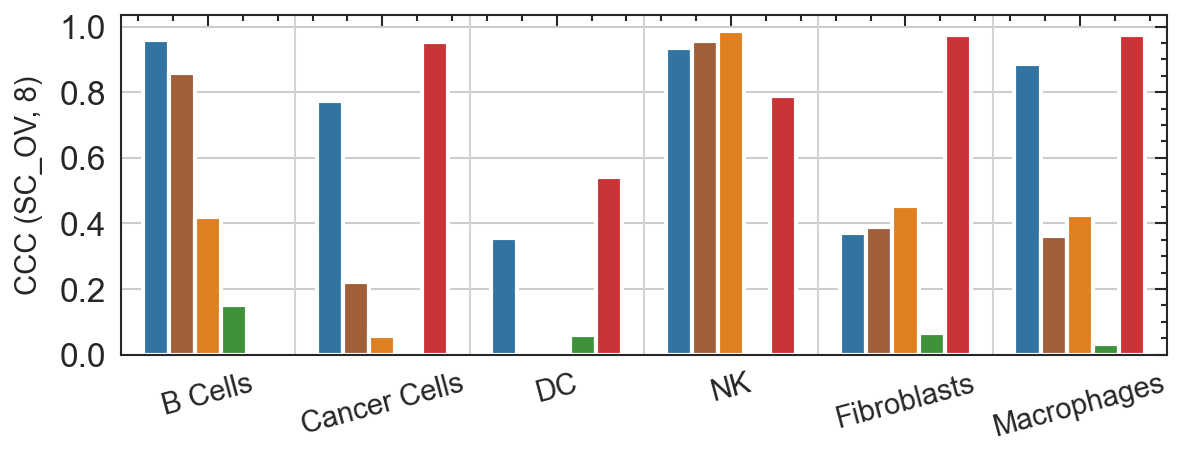

In [77]:
fig, ax4 = plt.subplots(1, 1, figsize=(4.5, 1.5))
# ds4
width = 0.75
hue_order_ds4 = [i for i in algos if i in algo_ct2ccc_df_ds4['Algorithm'].unique()]
g4 = sns.barplot(algo_ct2ccc_df_ds4, x="Cell type", y="CCC", hue="Algorithm", palette=[algo2color[algo] for algo in hue_order_ds4], ax=ax4, hue_order=hue_order_ds4, width=width)
# g4legend = g4.legend()
# sns.move_legend(g4, 'upper left',  bbox_to_anchor=(1, 1), ncol=2, title=None, frameon=False, fontsize=6, borderpad=0, handletextpad=0)
g4.legend([], [], frameon=False)
g4.set_xlabel('')
g4.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
g4.set_ylabel('CCC ' + '(' + 'SC_OV, 8' + ')', fontsize=7)
ax4.grid(axis='y')
for _x in range(7):
    ax4.axvline(_x - 0.5, color='lightgray', linewidth=0.5)
ax4.tick_params(axis='x', labelrotation=15, labelsize=7)
# # ds2
# hue_order_ds2 = [i for i in algos if i in algo_ct2ccc_df_ds2['Algorithm'].unique()]
# g5 = sns.barplot(algo_ct2ccc_df_ds2, x="Cell type", y="CCC", hue="Algorithm", palette=[algo2color[algo] for algo in hue_order_ds2], ax=ax5, hue_order=hue_order_ds2)
# # g5legend = g5.legend()
# # sns.move_legend(g5, 'upper left',  bbox_to_anchor=(1, 1), ncol=2, title=None, frameon=False, fontsize=6, borderpad=0, handletextpad=0)
# g5.legend([], [], frameon=False)
# g5.set_xlabel('')
# g5.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
# g5.set_ylabel('CCC ' + '(' + ds2 + ')')
# # ax5.yaxis.set_label_position("right")
# # plt.tight_layout()
plt.savefig(os.path.join(fig_dir, 'sc_ovarian_cancer.svg'), dpi=300)